In [1]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [2]:
import pandas as pd
import numpy as np
from os import path
import json
from ast import literal_eval
from public_MAPE import score_function
from time import time
import matplotlib.pyplot as plt
import matplotlib
width=15.0
height=7.5
plt.style.use("bmh")
matplotlib.rcParams['figure.figsize'] = (width, height)
all_colors = [parameter['color'] for parameter in plt.rcParams['axes.prop_cycle']]

In [4]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [8]:
from scipy.fftpack import fft
from scipy.signal import blackman
freq = 250
T = 1./freq
N = 75000
middle_N = int(N/2)

# Load data

In [3]:
data_dir = "data"

train = pd.read_csv(path.join(data_dir, "train_input.csv"), sep=';', index_col=0)
ages = pd.read_csv(path.join(data_dir, "train_output.csv"), sep=';', index_col=0)

# Testing with samples

In [4]:
id_18 = 479
id_28 = 533
id_38 = 127
id_48 = 217
id_58 = 236
id_68 = 298
idxs = [id_18, id_28, id_38, id_48, id_58, id_68]
ag = ["18", "28", "38", "48", "58", "68"]

In [5]:
samples = train.iloc[idxs, 1:-1].values

NameError: name 'idxs' is not defined

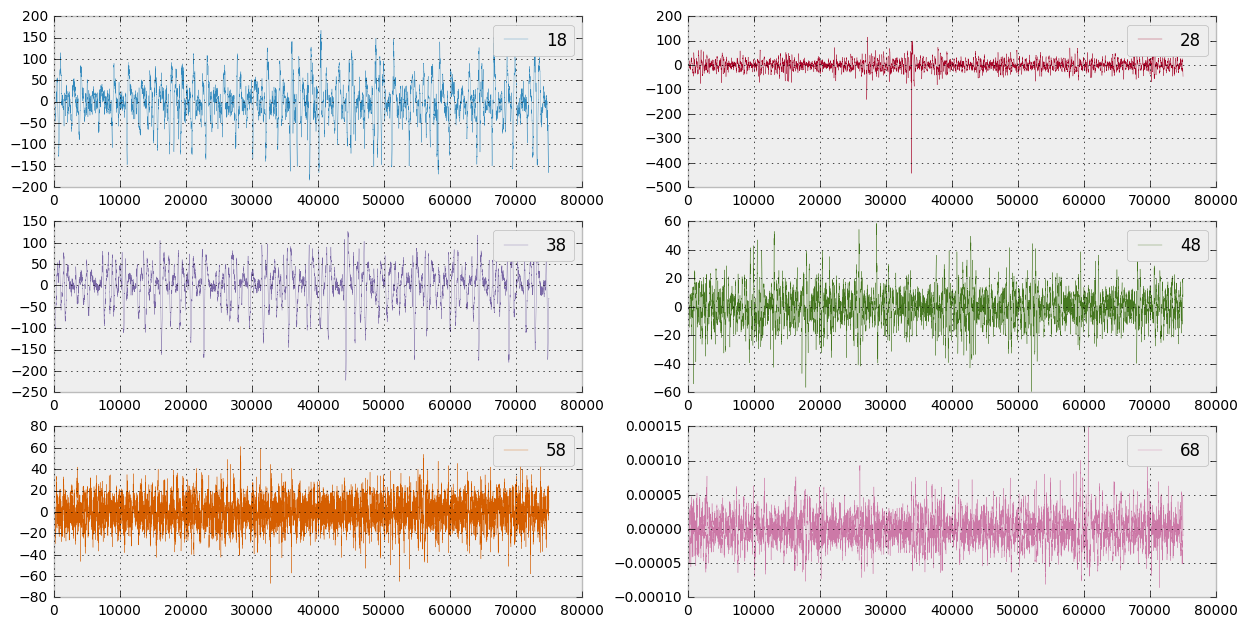

In [6]:
f, axs = plt.subplots(3, 2)
for row in range(3):
    for col in range(2):
        idx = col + 2*row
        axs[row, col].plot(samples[idx, :], linewidth=0.25, color=all_colors[idx], label=ag[idx])
        axs[row, col].legend()
# plt.plot(sample, linewidth=0.5)
#plt.savefig(path.join("figures", "EGG_all_ages.png"), format="png")

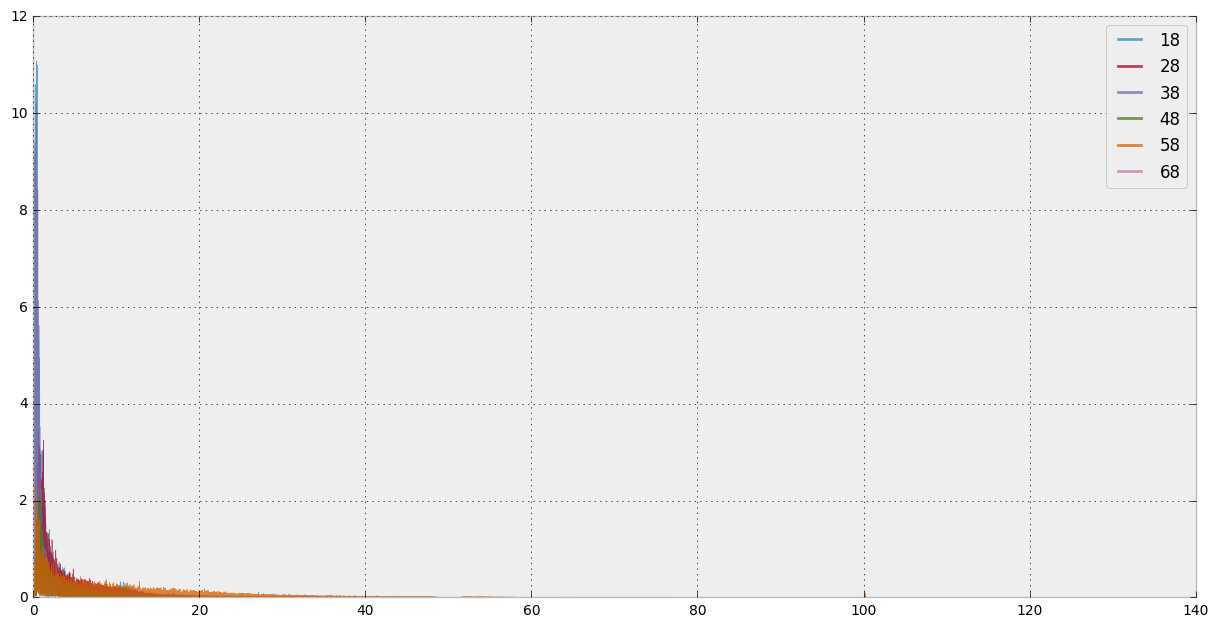

In [21]:
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
for idx in range(6):
    yf = fft(samples[idx, :])
    plt.plot(xf, 2.0/N * np.abs(yf[0:middle_N]), linewidth=0.5, alpha=0.75, color=all_colors[idx], label=ag[idx])
plt.axis("auto")
leg = plt.legend()
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)
# plt.savefig(path.join("figures", "FFT_56.png"), format="png")

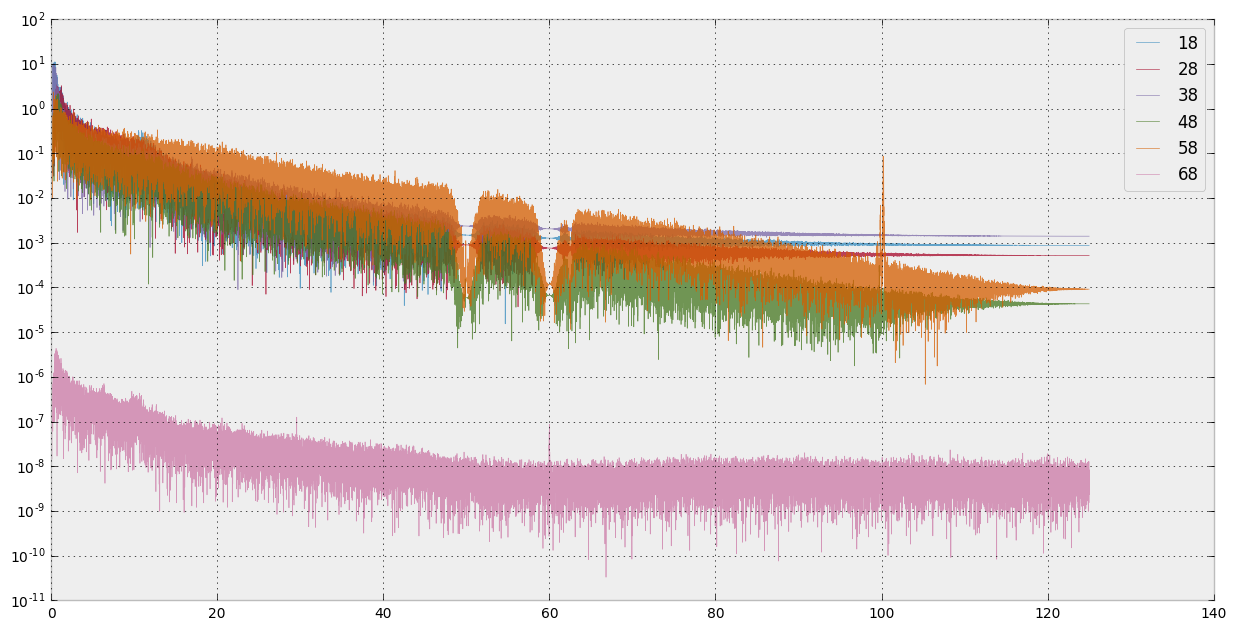

In [14]:
# cut = np.where(xf >= 80)[0][0]
cut = 1
for idx in range(6):
    yf = fft(samples[idx, :])
    plt.semilogy(xf[cut:middle_N], 2.0/N * np.abs(yf[cut:middle_N]), linewidth=0.5, color=all_colors[idx], alpha=0.75, label=ag[idx])
plt.axis("auto")
plt.legend()
#plt.savefig(path.join("figures", "FFT_semilog_all.png"), format="png")

# Dealing with the FFT

In [9]:
EEG = train.iloc[:, 1:-1]

In [10]:
def get_spectre(row):
    global N
    yf = fft(row)
    ampl = 2.0/N * np.abs(yf)
    return ampl

In [11]:
FFT = EEG.apply(get_spectre, axis=1).iloc[:,:middle_N]

## Binarizing

In [19]:
size_bins = 10
FFT["BINS"] = size_bins*((ages - 8) // size_bins) + 8
FFT["BINS"] = FFT["BINS"].replace(68, 68-size_bins)

In [20]:
FFT_mean = FFT.groupby("BINS").mean()

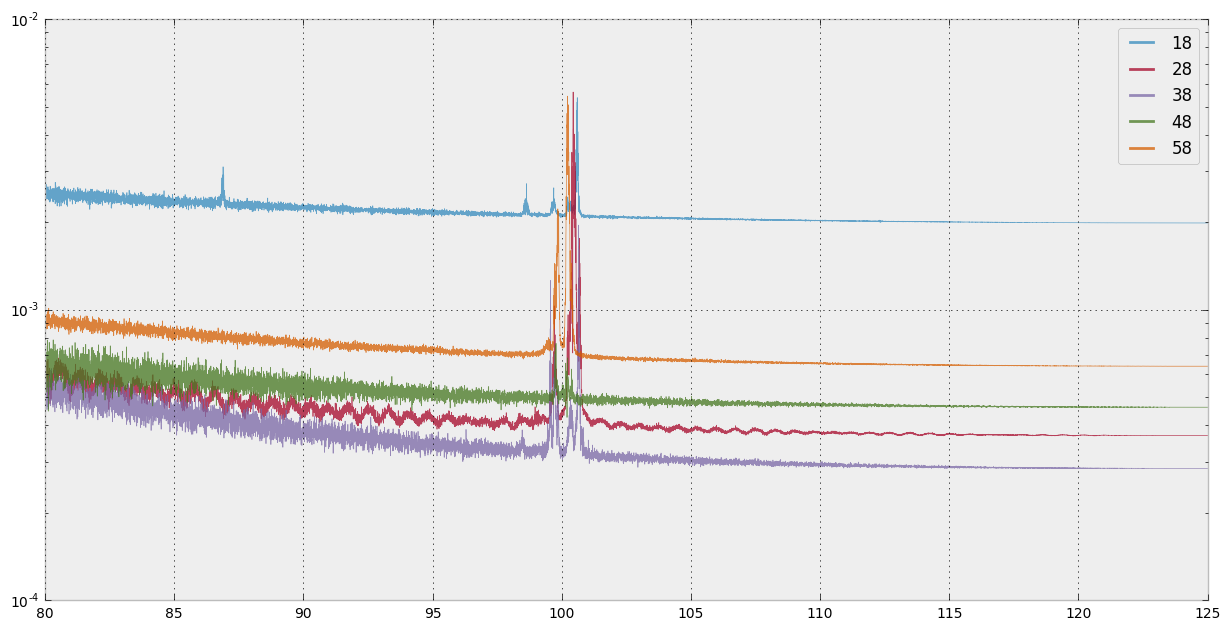

In [21]:
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
cut = np.where(xf >= 80)[0][0]
ags = list(FFT_mean.index)
for idx, age in enumerate(ags):
    ampl = FFT_mean.loc[age,:].values
    plt.semilogy(xf[cut:middle_N], ampl[cut:middle_N], linewidth=0.5, color=all_colors[idx], alpha=0.75, label=age)
plt.axis("auto")
leg = plt.legend()
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)
#plt.savefig(path.join("figures", "FFT_semilog_all.png"), format="png")

In [22]:
FFT["BINS"].value_counts()

38    180
18    135
28    120
48     90
58     56
Name: BINS, dtype: int64

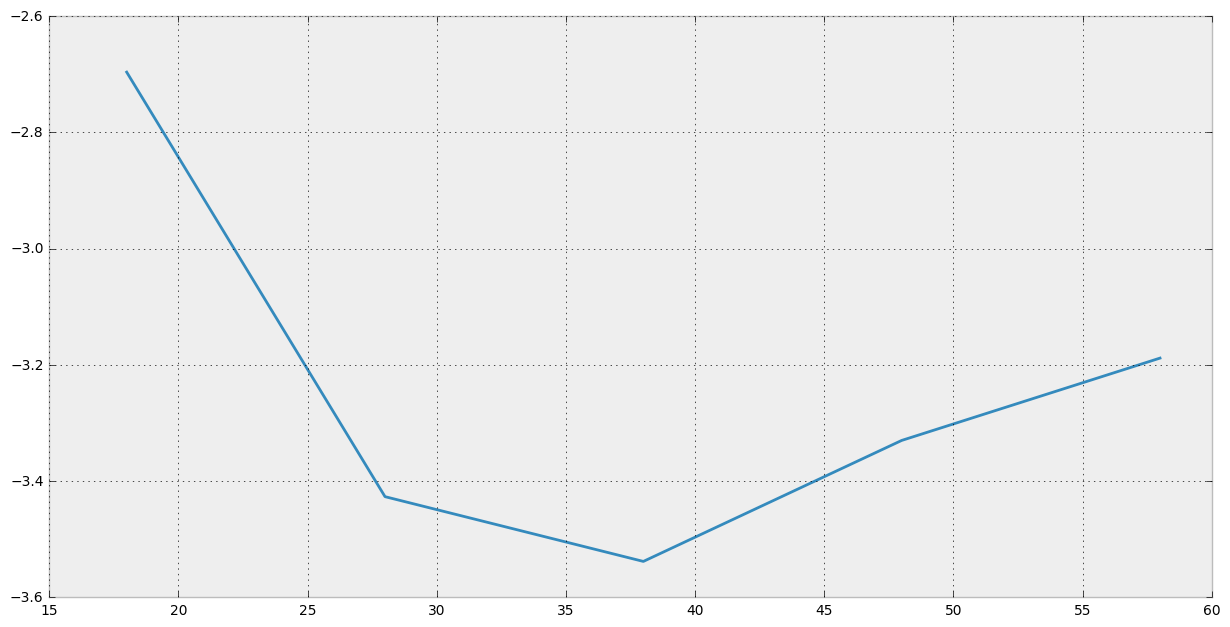

In [24]:
start_freq = 105
begin = int(start_freq*(N/freq))
mean_fft = np.log10(FFT_mean.iloc[:,begin:].mean(axis=1))
plt.plot(mean_fft)

## Test with different size_bins

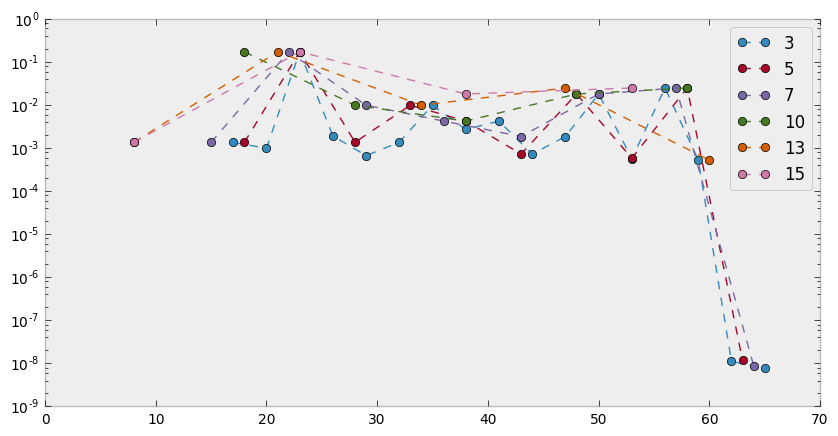

In [25]:
size_bins = [3, 5, 7, 10, 13, 15]
start_freq = 105
begin = int(start_freq*(N/freq))
plt.figure(figsize=(10.0,5.0))
for size_bin in size_bins:
    FFT["BINS"] = size_bin*((ages - 8) // size_bin) + 8
    FFT["BINS"] = FFT["BINS"].replace(68, 68-size_bin)
    FFT_mean = FFT.groupby("BINS").max()
    mean_fft = FFT_mean.iloc[:,begin:].mean(axis=1)
    plt.semilogy(mean_fft, '--o', label=size_bin, linewidth=1)
plt.legend()
ax = plt.gca()
ax.grid(False)

## Mean of the FFT for each sample without binarizing

In [165]:
###### WARNING: BEWARE OF THE COLUMN BINS !!!!!!!!!!
start_freq = 0
end_freq = 125
begin = int(start_freq*(N/freq))
end = int(end_freq*(N/freq))
mean_fft = pd.DataFrame(FFT.iloc[:,begin:end].mean(axis=1), columns=["VALS"])

In [161]:
size_bin = 10
min_ages = ages.min()
mean_fft["BINS"] = size_bin*((ages - min_ages) // size_bin) + min_ages
mean_fft["BINS"] = mean_fft["BINS"].replace(68, 68-size_bin)

In [162]:
mean_fft["BINS"].value_counts()

38    180
18    135
28    120
48     90
58     56
Name: BINS, dtype: int64

In [163]:
mean_fft_bins = mean_fft.groupby("BINS").mean()

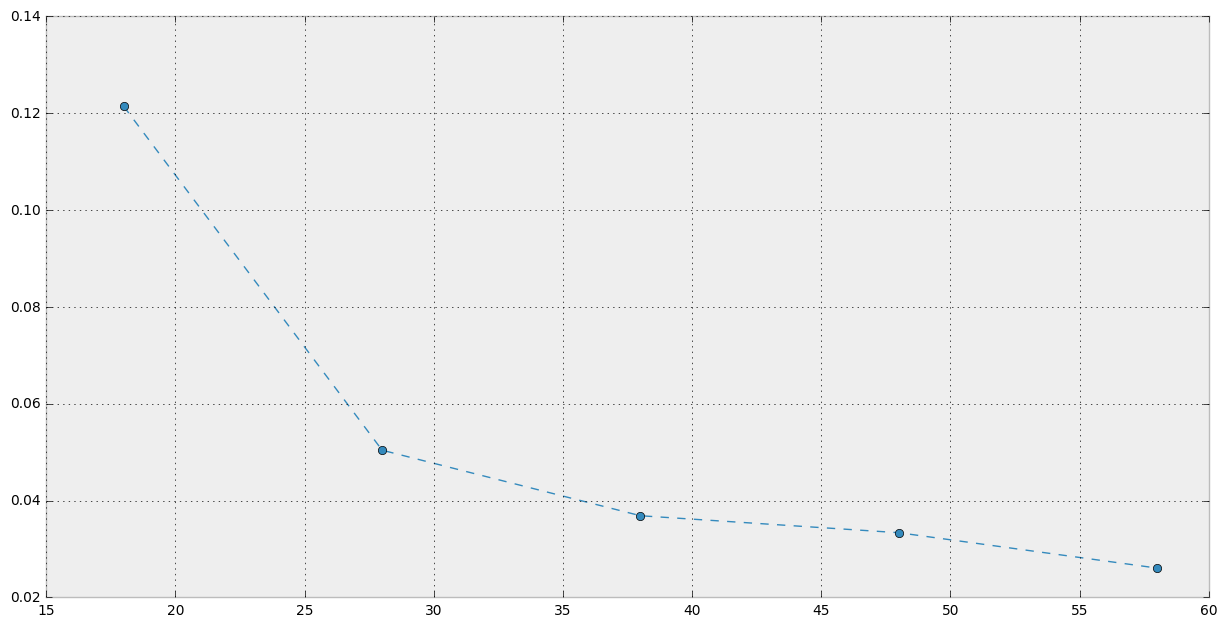

In [164]:
plt.plot(mean_fft_bins, '--o', linewidth=1)

In [131]:
X = mean_fft_bins.values
#y = ages.values
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Visualization of the mean by age

In [166]:
mean_fft_age = pd.concat([ages, mean_fft], axis=1)
mean_fft_age.columns = ["ages", "mean_fft"]
mean_fft_age = mean_fft_age.set_index("ages")
mean_fft_age = mean_fft_age.sort_index()
mean_fft_age = mean_fft_age.reset_index().groupby("ages").mean()

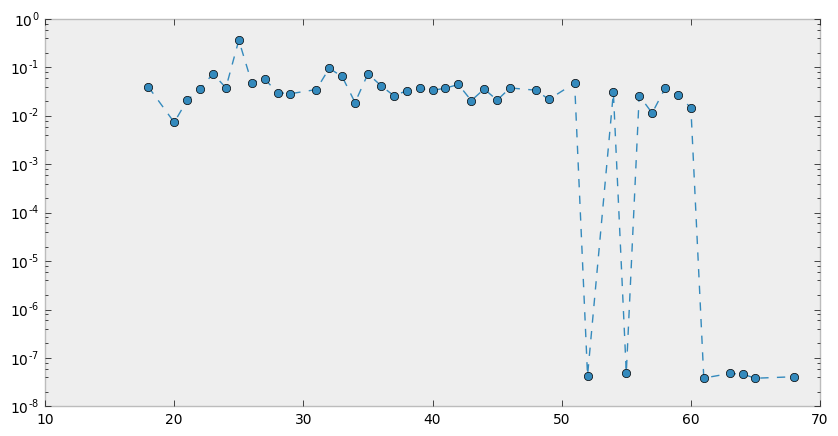

In [167]:
plt.figure(figsize=(10.0,5.0))
plt.semilogy(mean_fft_age, '--o', linewidth=1)
ax = plt.gca()
ax.grid(False)

### Linear Regression

In [139]:
from scipy.stats import pearsonr
pearsonr(np.log10(X).reshape(-1), np.array(list(mean_fft_bins.index)))

(-0.95449532144341398, 0.011572606079742139)

In [140]:
bins = np.array(list(mean_fft_bins.index))

In [136]:
list(mean_fft_bins.index)

[18, 28, 38, 48, 58]

In [150]:
reg = LinearRegression()
reg.fit(np.log10(X), bins)
pred = reg.predict(np.log10(X_all[:,0]).reshape(-1, 1))

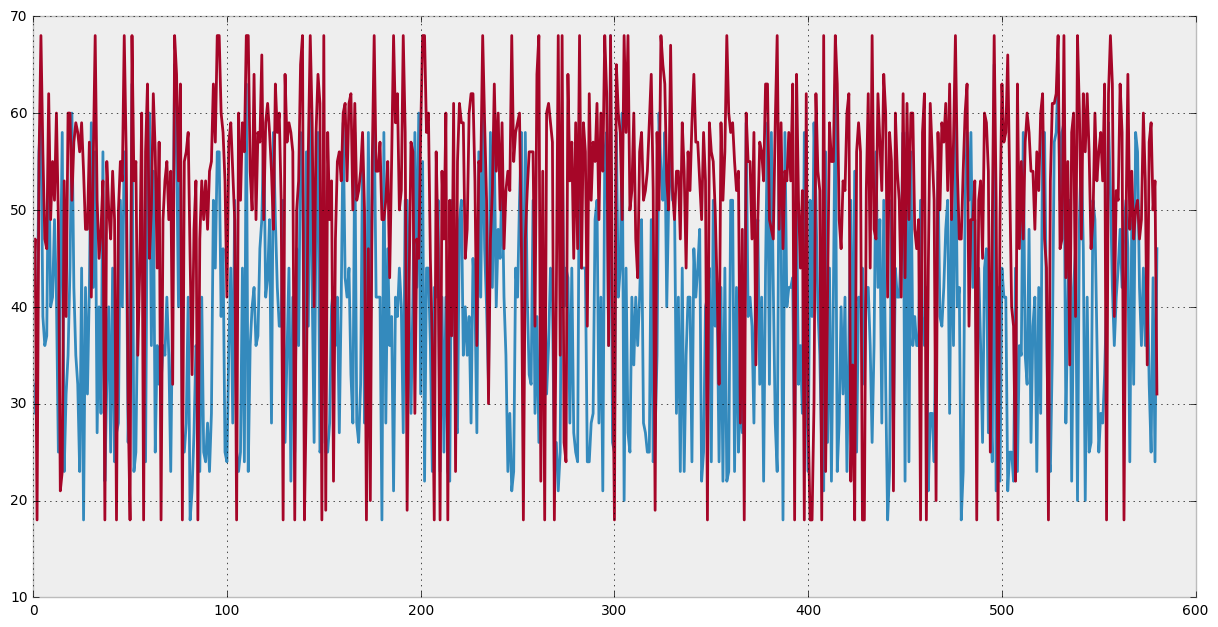

In [158]:
plt.plot(ages.values)
y_pred = np.round(np.maximum(np.minimum(pred, 68), 18))
plt.plot(y_pred)
plt.show()

In [159]:
score_function(ages.values, y_pred)

56.696281325786082

In [148]:
np.log10(X_all[:,0]).shape

(581,)

In [156]:
np.minimum(pred, 68)

array([ 41.45943479,  47.10678433,   5.43633525,  54.9565337 ,
        68.        ,  55.65812319,  46.64942047,  46.04137764,
        62.36891661,  49.34682528,  55.00798696,  51.06823615,
        60.44427569,  49.15076225,  21.05617686,  23.18192207,
        52.61453311,  39.14992053,  59.83012613,  60.01183814,
        51.41872791,  56.52996606,  59.25367155,  57.76424107,
        56.25473111,  58.52559652,  53.85594502,  47.5175493 ,
        47.98059393,  56.55752532,  40.92266745,  54.81042461,
        68.        ,  50.9792369 ,  45.28081037,  47.99275043,
        53.21451624,  -9.06529685,  55.12963401,  50.20478949,
        46.56067243,  53.61605802,  48.67946721,  -2.07217613,
        49.76043195,  54.50862061,  52.67726973,  68.        ,
        56.46503122,  29.88087487,  18.04934464,  68.        ,
        53.29333281,  54.57582442,  35.28078364,  44.14794002,
        60.36070548,   4.67729621,  56.32305537,  63.04343903,
        45.33795535,  50.15067404,  62.34799072,  56.16